# Optimizing Model - Adding Average Weather Delay

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_01.csv', sep = ',')

In [3]:
data_weather = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/weather.csv', sep = ',')

In [4]:
df_flight_info = data_flight_info.copy()
df_weather = data_weather.copy()

In [5]:
df_weather['value'] = df_weather['value'].str.lower()
# create a list of our conditions
conditions = [
    (df_weather['value'].str.contains('sunny')),
    (df_weather['value'].str.contains('cloud')),
    (df_weather['value'].str.contains('mist')),
    (df_weather['value'].str.contains('fog')),
    (df_weather['value'].str.contains('overcast')),
    (df_weather['value'].str.contains('rain')),
    (df_weather['value'].str.contains('drizzle')),
    (df_weather['value'].str.contains('thunder')),
    (df_weather['value'].str.contains('snow')),
    (df_weather['value'].str.contains('sleet')),
    (df_weather['value'].str.contains('blizzard')),
    ]

# create a list of the values we want to assign for each condition
values = ['sunny', 'cloudy', 'cloudy','cloudy','cloudy','rain','rain','rain','snow','snow','snow']

# create a new column and use np.select to assign values to it using our lists as arguments
df_weather['weather_type'] = np.select(conditions, values)
df_weather['weather_type'].value_counts()

sunny     5503
cloudy    4324
rain      2860
snow      1412
Name: weather_type, dtype: int64

In [6]:
df_weather['value'].value_counts().sum()

14099

In [7]:
# Creating year, month, date columns
df_weather['year'] = pd.DatetimeIndex(df_weather['date']).year
df_weather['month'] = pd.DatetimeIndex(df_weather['date']).month
df_weather['day'] = pd.DatetimeIndex(df_weather['date']).day
df_weather['weekday'] = ((pd.DatetimeIndex(df_weather['date']).dayofweek))

#### Merging weather data with flight data

In [8]:
df_weather.rename(columns={'date': 'fl_date', 'airport_code': 'origin'}, inplace=True)

In [9]:
df_flight_info = pd.merge(df_flight_info, df_weather[['fl_date','origin','weather_type']],  how='left', left_on=['fl_date','origin'], right_on = ['fl_date','origin'])


In [10]:
df_flight_info.isnull().sum()

fl_date                    0
mkt_unique_carrier         0
op_unique_carrier          0
op_carrier_fl_num          0
origin                     0
crs_dep_time               0
dep_time                   0
dep_delay                  0
dest                       0
arr_time                   0
arr_delay                  0
crs_arr_time               0
crs_elapsed_time           0
actual_elapsed_time        0
distance                   0
carrier_delay              0
weather_delay              0
nas_delay                  0
security_delay             0
late_aircraft_delay        0
year                       0
month                      0
day                        0
weekday                    0
weather_type           44738
dtype: int64

In [11]:
# Dropping the small number of null weather types
df_flight_info = df_flight_info.dropna()

In [12]:
# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [13]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]

In [14]:
# Getting Average Weather Delay
weather_grouped1 = df_flight_info.groupby(by=['origin','month']).mean()
weather_grouped1.reset_index(inplace=True)
weather_grouped1['total_weather_delay'] = weather_grouped1['weather_delay']
weather_grouped1 = weather_grouped1[['origin','total_weather_delay']]

In [15]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]

# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(weather_grouped1, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(carrier_grouped, on = 'op_unique_carrier', how = 'outer')

## Model Training

In [16]:
#df_flight_info.isnull().sum()

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [18]:
# encoding df_flight_info 
df_flight_info["weather_type"] = df_flight_info["weather_type"].astype('category').cat.codes
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [19]:
df_flight_info.dtypes

fl_date                  object
mkt_unique_carrier       object
op_unique_carrier        object
op_carrier_fl_num         int64
origin                   object
crs_dep_time              int64
dep_time                float64
dep_delay               float64
dest                     object
arr_time                float64
arr_delay               float64
crs_arr_time              int64
crs_elapsed_time        float64
actual_elapsed_time     float64
distance                float64
carrier_delay           float64
weather_delay           float64
nas_delay               float64
security_delay          float64
late_aircraft_delay     float64
year                      int64
month                     int64
day                       int64
weekday                 float64
weather_type               int8
flight_number             int16
total_security_delay    float64
total_nas_delay         float64
average_route_time      float64
total_dep_delay         float64
total_arr_delay         float64
total_we

### Adding Total Weather Delay

In [20]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','year','month','day','weekday','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay','weather_type','total_weather_delay']]
y = df_flight_info['arr_delay']

In [21]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [22]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.263232
Model RMSE is:  38.565445536507454
Model R2 Score is:  0.18566658059011976


##### XGBoost

In [23]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  41.588499117246506
Model R2 Score is:  0.05299549060650344


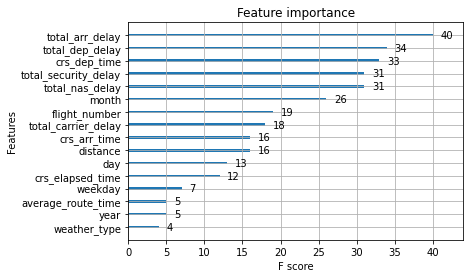

In [24]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

##### Linear Regression

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  40.810119203635075
Model R2 Score is:  0.07971073578474908


##### Ridge/Lasso Regression

In [26]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Model RMSE is:  40.810168488769264
Model R2 Score is:  0.07970851297294879
Model RMSE is:  40.93888393311902
Model R2 Score is:  0.07389415165022228


##### Random Forest

In [ ]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [ ]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))